<a href="https://colab.research.google.com/github/Tony6512/Kaggle-Datasets/blob/main/ab_testing_on_mobile_game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mobile-games-ab-testing/cookie_cats.csv


https://www.kaggle.com/datasets/yufengsui/mobile-games-ab-testing

# Intro

In [ ]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import scipy
import statsmodels.api as sm
import time

# visualization
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/kaggle/input/mobile-games-ab-testing/cookie_cats.csv')

In [ ]:
df.shape

(90189, 5)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [ ]:
# Strip extra spaces from all string entries in the DataFrame
df = df.map(lambda x: x.strip() if isinstance(x, str) else x)

In [ ]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [ ]:
df.tail()

,userid,version,sum_gamerounds,retention_1,retention_7
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False
90188,9999861,gate_40,16,False,False


In [ ]:
df.nunique()

userid            90189
version               2
sum_gamerounds      942
retention_1           2
retention_7           2
dtype: int64

In [ ]:
df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

no missing data

In [ ]:
df.duplicated().sum()

0

no duplicates

In [ ]:
df.columns

Index(['userid', 'version', 'sum_gamerounds', 'retention_1', 'retention_7'], dtype='object')

In [ ]:
df.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


In [ ]:
df.drop(['userid'], axis = 1, inplace = True)

In [ ]:
df.describe(exclude = [np.number])

,version,retention_1,retention_7
count,90189,90189,90189
unique,2,2,2
top,gate_40,False,False
freq,45489,50036,73408


In [ ]:
cts_feat = df.select_dtypes(include=[np.number]).columns
print(cts_feat)
print(cts_feat.shape)

Index(['sum_gamerounds'], dtype='object')
(1,)


In [ ]:
cat_feat = df.select_dtypes(include=["object", 'bool']).columns
print(cat_feat)
print(cat_feat.shape)

Index(['version', 'retention_1', 'retention_7'], dtype='object')
(3,)


# Data Exploration

In [ ]:
### no correlation between continuous data as there is only one
# plt.figure(figsize=(12, 10))
# sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, square=True, cmap='coolwarm', annot_kws={'size': 8}, fmt = '.2f')
# plt.title('Pearson')
# plt.show()
# plt.figure(figsize=(12, 10))
# sns.heatmap(df.select_dtypes(include=[np.number]).corr(method = 'spearman'), annot=True, square=True, cmap='coolwarm', annot_kws={'size': 8}, fmt = '.2f')
# plt.title('Spearman')
# plt.show()
# plt.figure(figsize=(12, 10))
# sns.heatmap(df.select_dtypes(include=[np.number]).corr(method = 'kendall'), annot=True, square=True, cmap='coolwarm', annot_kws={'size': 8}, fmt = '.2f')
# plt.title('Kendall')
# plt.show()
# None

## Continuous Features

In [ ]:
df.describe()
# df.describe(np.arange(0.1, 1, 0.1))

,sum_gamerounds
count,90189.000000
mean,51.872457
std,195.050858
min,0.000000
25%,5.000000
50%,16.000000
75%,51.000000
max,49854.000000


In [ ]:
df.nlargest(10, 'sum_gamerounds')

,version,sum_gamerounds,retention_1,retention_7
57702,gate_30,49854,False,True
7912,gate_30,2961,True,True
29417,gate_40,2640,True,False
43671,gate_30,2438,True,True
48188,gate_40,2294,True,True
46344,gate_30,2251,True,True
87007,gate_30,2156,True,True
36933,gate_40,2124,True,True
88328,gate_40,2063,True,True
6536,gate_40,2015,True,True


In [ ]:
df = df[df['sum_gamerounds'] < 3000]

In [ ]:
df.describe()

,sum_gamerounds
count,90188.000000
mean,51.320253
std,102.682719
min,0.000000
25%,5.000000
50%,16.000000
75%,51.000000
max,2961.000000


In [ ]:
low_rounds = df[df['sum_gamerounds'] < 51]
print(low_rounds.shape)

(67377, 4)


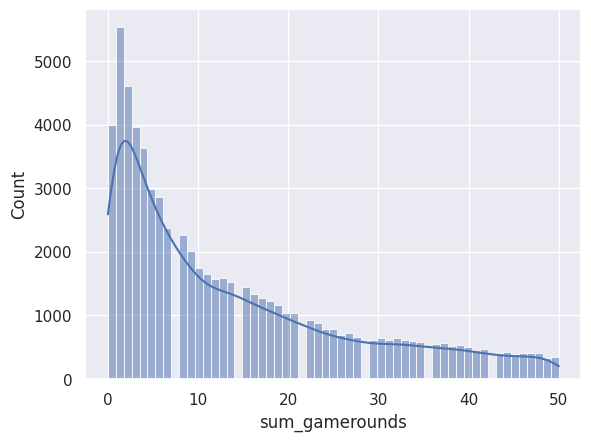

In [ ]:
sns.histplot(low_rounds , x = 'sum_gamerounds', kde = True)
plt.show()

In [ ]:
medium_rounds = df[(df['sum_gamerounds'] >= 51)&(df['sum_gamerounds'] <= 500)]
print(medium_rounds.shape)

(21956, 4)


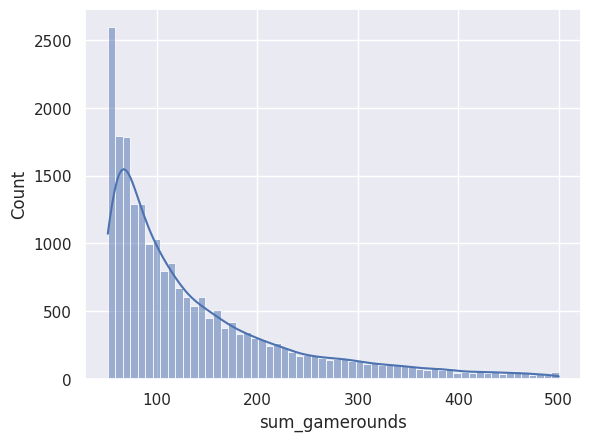

In [ ]:
sns.histplot(medium_rounds , x = 'sum_gamerounds', kde = True)
plt.show()

In [ ]:
high_rounds = df[(df['sum_gamerounds'] > 500)]
print(high_rounds.shape)

(855, 4)


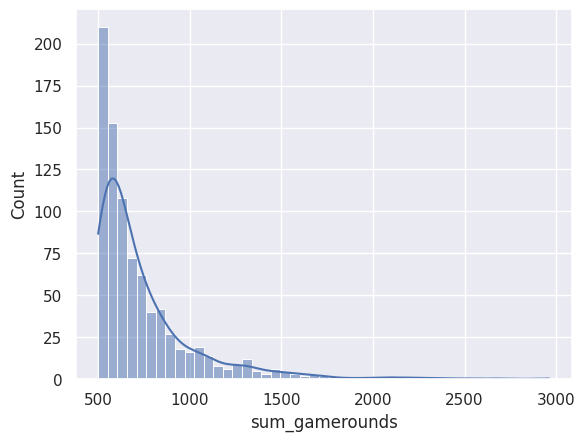

In [ ]:
sns.histplot(high_rounds , x = 'sum_gamerounds', kde = True)
plt.show()

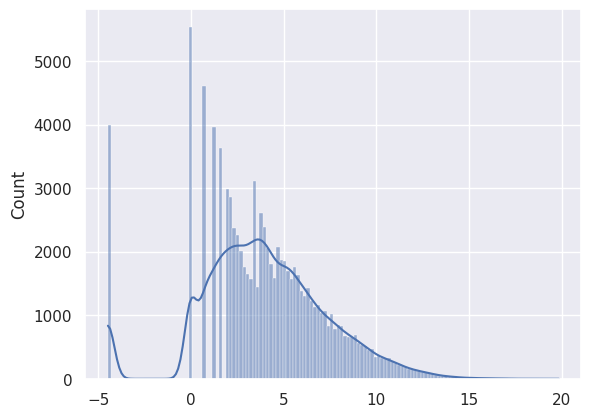

In [ ]:
# sns.histplot(x = np.log(df['sum_gamerounds'] + 1e-5), kde = True)
sns.histplot(x = scipy.stats.boxcox(df['sum_gamerounds'] + 1e-5)[0], kde = True)
plt.show()

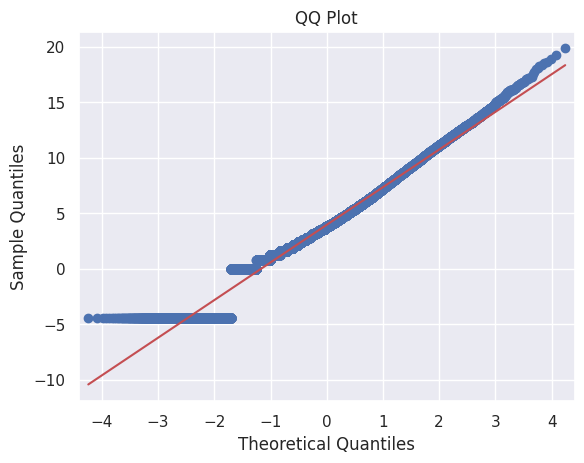

In [ ]:
# sm.qqplot(np.log(df['sum_gamerounds'] + 1e-5), line='s')
sm.qqplot(scipy.stats.boxcox(df['sum_gamerounds'] + 1e-5)[0], line='s')
plt.title('QQ Plot')
plt.show()
None

## Categorical Features

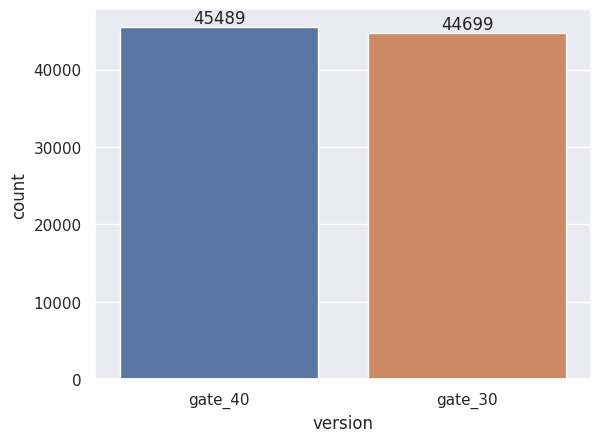

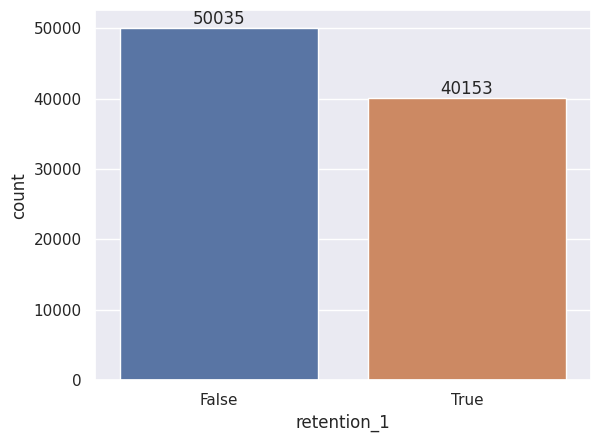

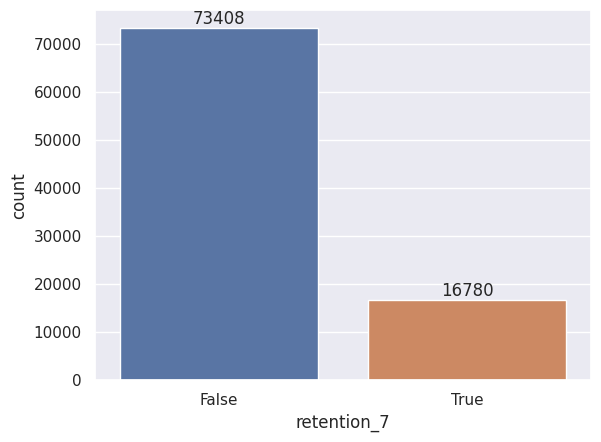

In [ ]:
for feat in cat_feat:
    ax = sns.countplot(df, x = feat,
            order = df[feat].value_counts().sort_values(ascending=False).index)
    ax.bar_label(ax.containers[0])
    plt.show()

## Comparing Versions

In [ ]:
df[df['sum_gamerounds']==30].shape

(642, 4)

In [ ]:
df[df['sum_gamerounds']==40].shape

(505, 4)

In [ ]:
df.groupby('version')['sum_gamerounds'].describe()

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,44699.0,51.342111,102.057598,0.0,5.0,17.0,50.0,2961.0
gate_40,45489.0,51.298776,103.294416,0.0,5.0,16.0,52.0,2640.0


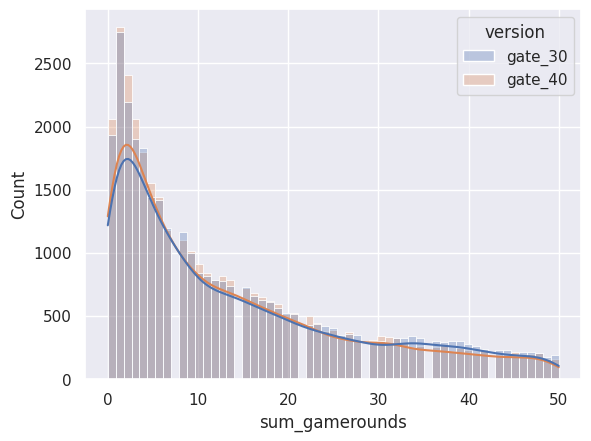

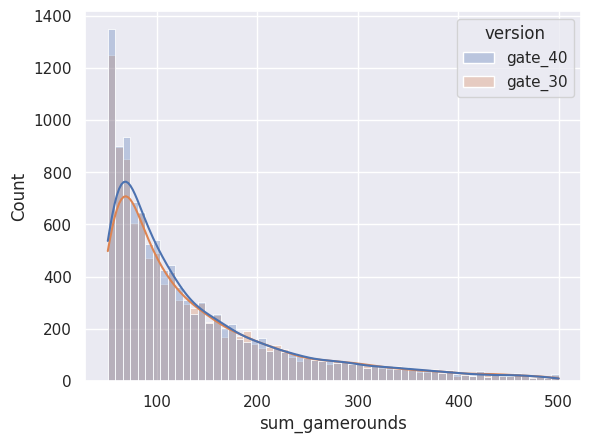

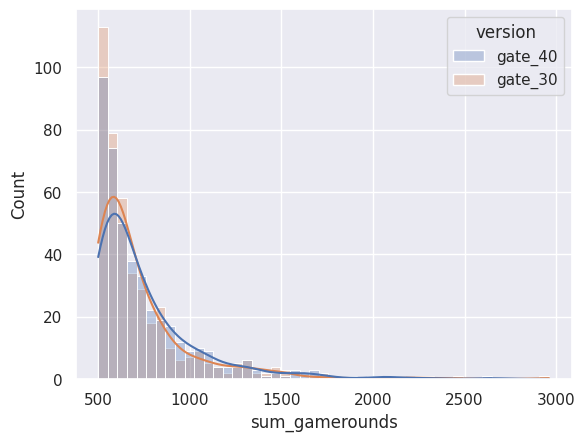

In [ ]:
rounds = [low_rounds, medium_rounds, high_rounds]
for r in rounds:
    sns.histplot(r , x = 'sum_gamerounds', hue = 'version', kde = True,
                 alpha = 0.3)
    plt.show()

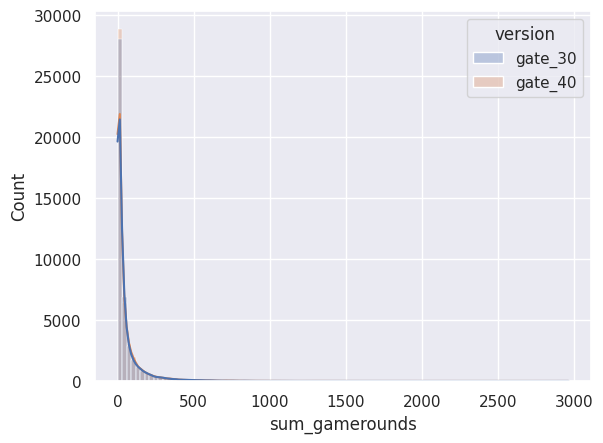

In [ ]:
sns.histplot(df , x = 'sum_gamerounds', hue = 'version', kde = True,
                 bins = 100, alpha = 0.3)
plt.show()

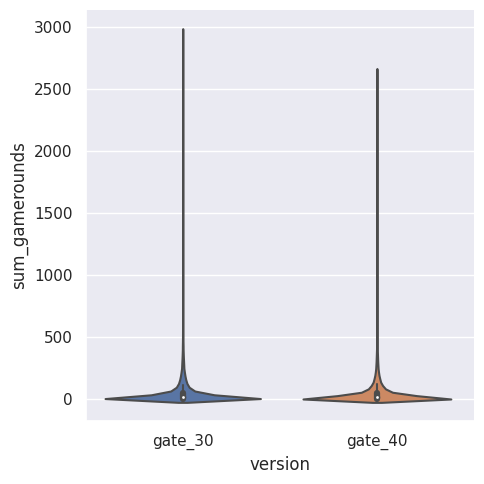

In [ ]:
sns.catplot(df, x = 'version', y = 'sum_gamerounds', kind = 'violin')
plt.show()

In [ ]:
for feat in cat_feat:
    if feat != 'version':
        print(feat)
        print(df.groupby('version')[feat].describe())
        print('-'*80)

retention_1
         count unique    top   freq
version                            
gate_30  44699      2  False  24665
gate_40  45489      2  False  25370
--------------------------------------------------------------------------------
retention_7
         count unique    top   freq
version                            
gate_30  44699      2  False  36198
gate_40  45489      2  False  37210
--------------------------------------------------------------------------------


In [ ]:
pd.crosstab(df['version'], df['retention_1'], normalize='index')
# pd.crosstab(df['version'], df['retention_1])

retention_1,False,True
version,,
gate_30,0.551802,0.448198
gate_40,0.557717,0.442283


In [ ]:
pd.crosstab(df['version'], df['retention_7'], normalize='index')
# pd.crosstab(df['version'], df['retention_7])

retention_7,False,True
version,,
gate_30,0.809817,0.190183
gate_40,0.818000,0.182000


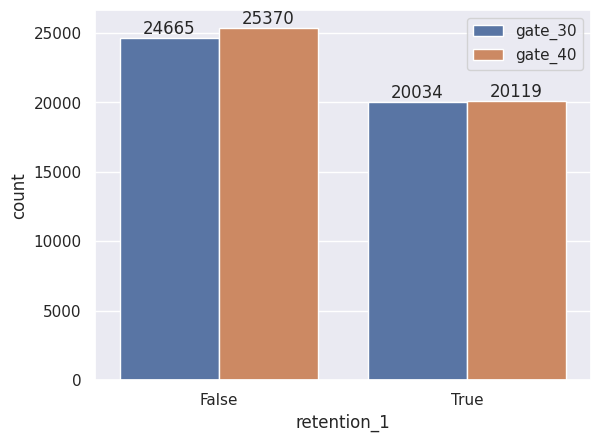

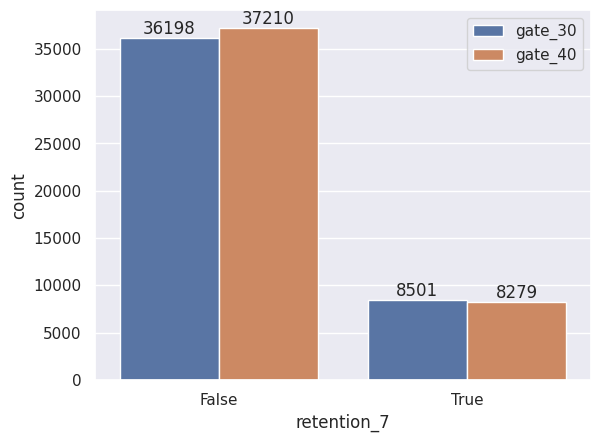

In [ ]:
for feat in cat_feat:
    if feat != 'version':
        ax = sns.countplot(df, x = feat, hue = 'version'
                # ,order = df[feat].value_counts().sort_values(ascending=False).index
                          )
        # ax.bar_label(ax.containers[0])
        for container in ax.containers:
            ax.bar_label(container)
        plt.legend(loc='best')
        plt.show()

# Removing Outliers

In [ ]:
## remove people who have not played and played very little
df = df[df['sum_gamerounds']>5]

In [ ]:
df.shape

(65471, 4)

In [ ]:
constant = 1e-5
transformed_data, lambda_param = scipy.stats.boxcox(df['sum_gamerounds'] + constant)
print("Lambda parameter:", lambda_param)
# original_data = scipy.stats.inv_boxcox(transformed_data, lambda_param)

Lambda parameter: -0.19766492812496894


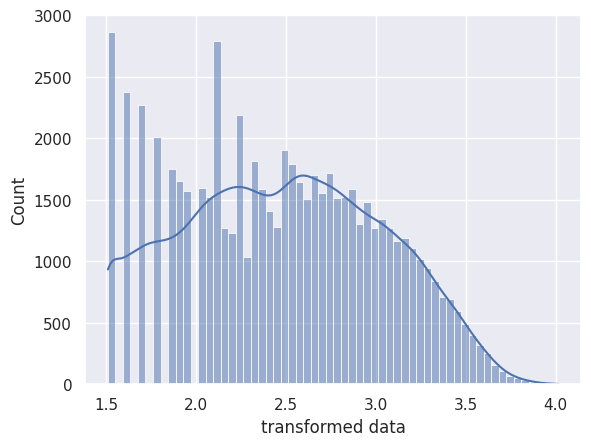

In [ ]:
sns.histplot(x = transformed_data, kde = True)
plt.xlabel('transformed data')
plt.show()

## IQR Method

In [ ]:
Q1 = np.percentile(transformed_data, 25)
Q3 = np.percentile(transformed_data, 75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_data = transformed_data[(transformed_data >= lower_bound) & (transformed_data <= upper_bound)]

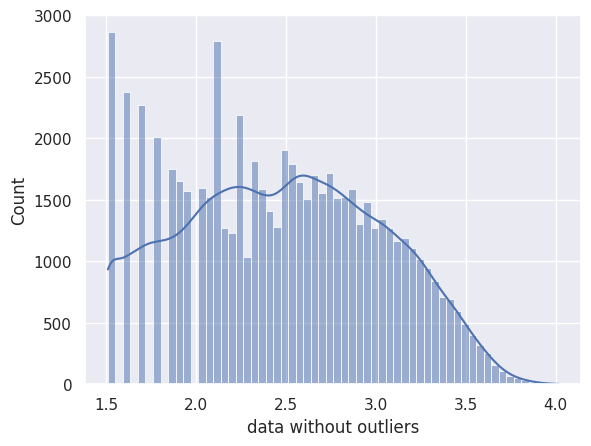

In [ ]:
sns.histplot(x = filtered_data, kde = True)
plt.xlabel('data without outliers')
plt.show()

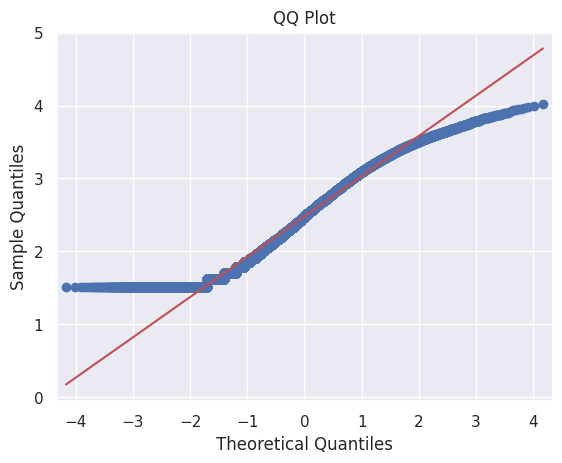

In [ ]:
sm.qqplot(filtered_data, line='s')
plt.title('QQ Plot')
plt.show()
None

In [ ]:
def boxcox_inverse(transformed_data, lambda_param, constant):
    if lambda_param == 0:
        return np.exp(transformed_data) - constant
    else:
        return (lambda_param * transformed_data + 1) ** (1 / lambda_param) - constant

original_data = boxcox_inverse(filtered_data, lambda_param, constant)

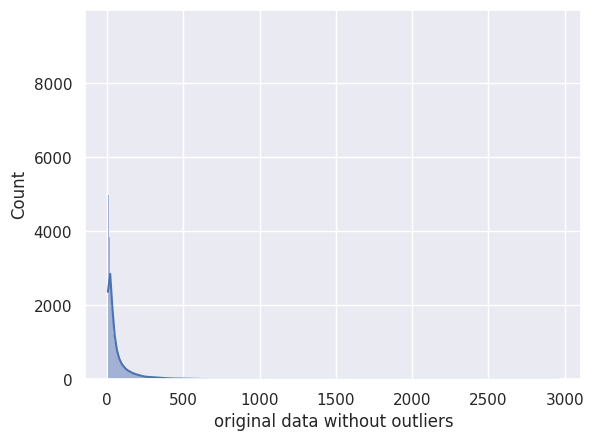

In [ ]:
sns.histplot(x = original_data, kde = True)
plt.xlabel('original data without outliers')
plt.show()

In [ ]:
original_data.max()

2960.999999999997

In [ ]:
original_data.shape

(65471,)

In [ ]:
def IQRmethod(data):
    constant = 1e-5
    transformed_data, lambda_param = scipy.stats.boxcox(data + constant)

    Q1 = np.percentile(transformed_data, 25)
    Q3 = np.percentile(transformed_data, 75)

    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    filtered_data = transformed_data[(transformed_data >= lower_bound) & (transformed_data <= upper_bound)]

    def boxcox_inverse(transformed_data, lambda_param, constant):
        if lambda_param == 0:
            return np.exp(transformed_data) - constant
        else:
            return (lambda_param * transformed_data + 1) ** (1 / lambda_param) - constant

    original_data = boxcox_inverse(filtered_data, lambda_param, constant)
    return original_data

In [ ]:
gate30 = df[df['version'] == 'gate_30']
gate40 = df[df['version'] == 'gate_40']

A_group = IQRmethod(gate30['sum_gamerounds'])
B_group = IQRmethod(gate40['sum_gamerounds'])

In [ ]:
print(f'Size of group A (gate30): {A_group.shape[0]}')
print(f'Size of group B (gaet40): {B_group.shape[0]}')

Size of group A (gate30): 32643
Size of group B (gaet40): 32828


## Z-score Method

In [ ]:
z_scores = np.abs(scipy.stats.zscore(transformed_data))
indices = np.where(z_scores <= 3)[0]

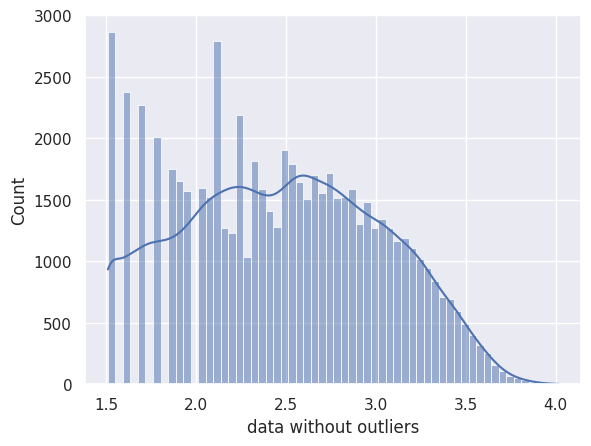

In [ ]:
sns.histplot(x = transformed_data[indices], kde = True)
plt.xlabel('data without outliers')
plt.show()

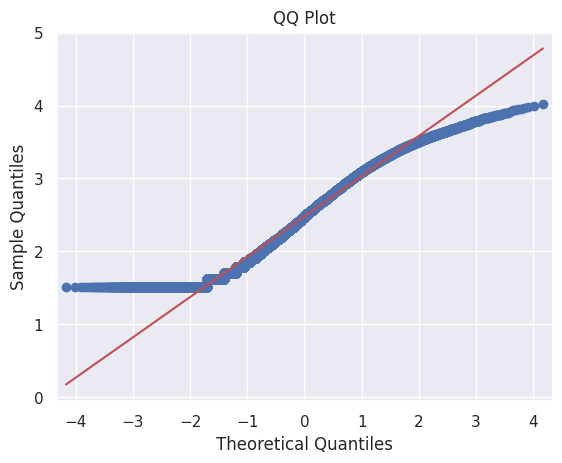

In [ ]:
sm.qqplot(transformed_data[indices], line='s')
plt.title('QQ Plot')
plt.show()
None

In [ ]:
def boxcox_inverse(transformed_data, lambda_param, constant):
    if lambda_param == 0:
        return np.exp(transformed_data) - constant
    else:
        return (lambda_param * transformed_data + 1) ** (1 / lambda_param) - constant

original_data = boxcox_inverse(transformed_data[indices], lambda_param, constant)

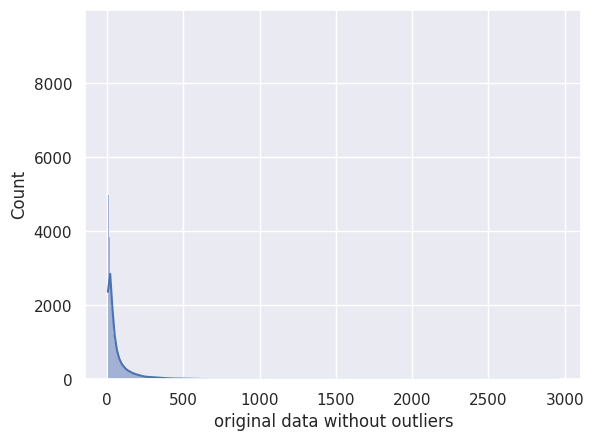

In [ ]:
sns.histplot(x = original_data, kde = True)
plt.xlabel('original data without outliers')
plt.show()

In [ ]:
original_data.max()

2960.999999999997

In [ ]:
original_data.shape

(65471,)

# Sampling

Question: Has the average number of game sessions increased by n sessions?

Objective: To determine if moving the gate from 30 to 40 has increased the average number of game sessions by n sessions.

Null Hypothesis (H0): The average number of game sessions in group B has not increased by n sessions compared to group A.

Alternative Hypothesis (H1): The average number of game sessions in group B has increased by n sessions compared to group A.

In [ ]:
import statsmodels.stats.api as sms
seed = 0
n = 3
mean_diff = n
std_dev = np.concatenate((A_group, B_group), axis = 0).std()
alpha = 0.05
beta = 0.20   ## 0.20 is standard
power = 1 - beta ##probability that a statistical test will correctly reject a null hypothesis when it is false

effect_size = mean_diff / std_dev

power_analysis = sms.NormalIndPower()

sample_size = power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, ratio=1)

print(f"Required sample size for comparing two means: {sample_size:.2f}")

Required sample size for comparing two means: 23148.73


In [ ]:
df_A = pd.DataFrame(A_group, columns = ['sum_gamerounds'])
df_B = pd.DataFrame(B_group, columns = ['sum_gamerounds'])

A_sample = df_A.sample(n=int(sample_size+1), replace=False, random_state=seed)
B_sample = df_B.sample(n=int(sample_size+1), replace=False,random_state=seed)
## replace = False b/c test usually require independence

In [ ]:
print(f'Size of A sample (gate30): {A_sample.shape[0]}')
print(f'Size of B sample (gaet40): {B_sample.shape[0]}')

Size of A sample (gate30): 23149
Size of B sample (gaet40): 23149


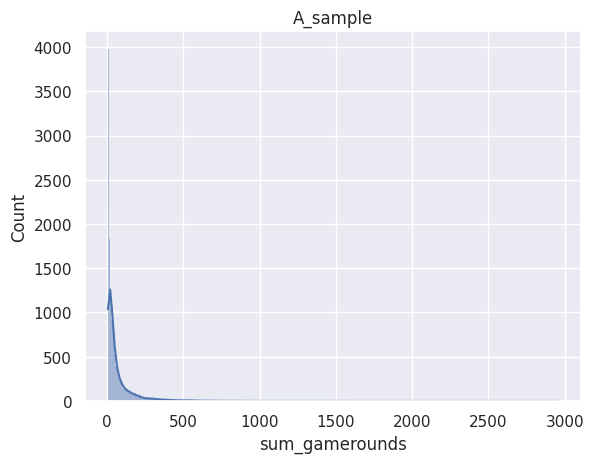

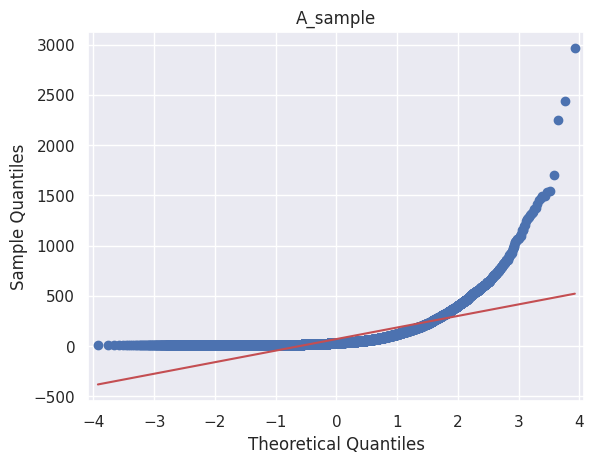

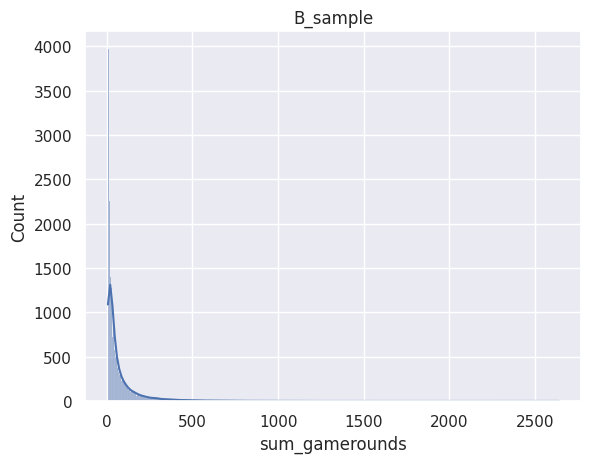

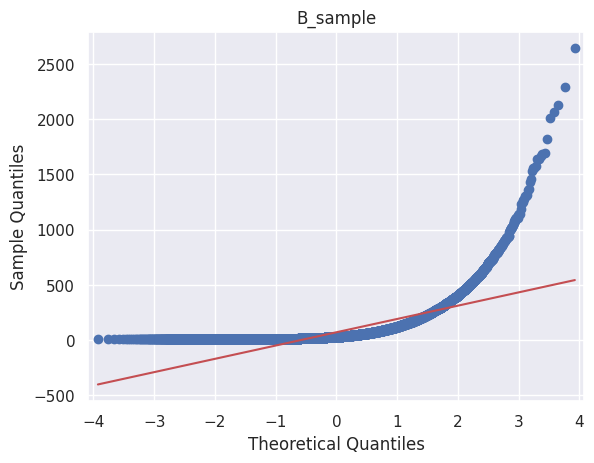

In [ ]:
samples = {'A_sample': A_sample, 'B_sample': B_sample }
for (name, sample) in samples.items():
    sns.histplot(sample,  x = 'sum_gamerounds', kde = True)
    plt.title(name)
    plt.show()
    sm.qqplot(sample['sum_gamerounds'], line='s')
    plt.title(name)
    plt.show()
    None

# A/B Testing

Has the average number of game sessions increased by n sessions?

In [ ]:
# Assumptions:
# independence (achieved from random sampling)
# Check normality (can be relaxed if the sample size is large by Central Limit Theorem)
# If Normal Distribution, check homogeneity of variances
# Steps:
# Split and Define Control Group and Test Group
# Apply Shapiro Test for normality
# If normal, then apply Levene Test for homogeneity of variances
# If normal and homogeneous, then apply T-Test (parametric)
# If normal and inhomogeneous, then apply Welch Test (parametric)
# If not normal, then apply Mann Whitney U Test (non-parametric)

In [ ]:
# Many parametric tests assume that the data are normally distributed.
# These tests often have more statistical power than non-parametric tests
# when the assumptions are met.

Shapiro-Wilk Test assesses the null hypothesis that the data is normally distributed. A p-value less than a chosen significance level (e.g., 0.05) indicates that the data is not normally distributed.

In [ ]:
samples = {'A_sample': A_sample, 'B_sample': B_sample }
for (name, sample) in samples.items():
    shapiro_test = scipy.stats.shapiro(sample['sum_gamerounds'])
    print(name)
    print('Shapiro-Wilk Test statistic:', shapiro_test.statistic)
    print('p-value:', shapiro_test.pvalue)
    print('-'*70)

A_sample
Shapiro-Wilk Test statistic: 0.5270266723323731
p-value: 8.820221123892599e-119
----------------------------------------------------------------------
B_sample
Shapiro-Wilk Test statistic: 0.517733676532412
p-value: 2.5678476263833837e-119
----------------------------------------------------------------------


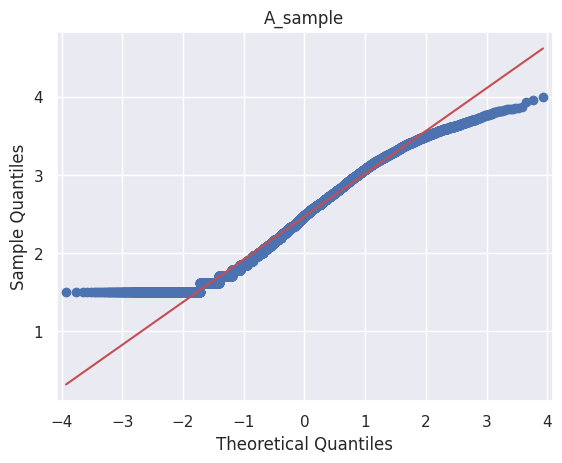

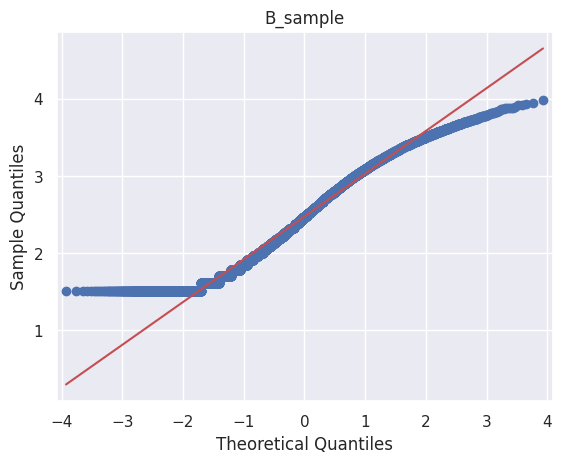

In [ ]:
samples = {'A_sample': A_sample, 'B_sample': B_sample }
for (name, sample) in samples.items():
    sm.qqplot(scipy.stats.boxcox(sample['sum_gamerounds']+1e-5)[0], line='s')
    plt.title(name)
    plt.show()
    None

In [ ]:
samples = {'A_sample': A_sample, 'B_sample': B_sample }
for (name, sample) in samples.items():
    shapiro_test = scipy.stats.shapiro(scipy.stats.boxcox(sample['sum_gamerounds']+1e-5)[0])
    print(name)
    print('Shapiro-Wilk Test statistic:', shapiro_test.statistic)
    print('p-value:', shapiro_test.pvalue)
    print('-'*70)

A_sample
Shapiro-Wilk Test statistic: 0.9790153174046518
p-value: 9.040697367051891e-49
----------------------------------------------------------------------
B_sample
Shapiro-Wilk Test statistic: 0.9776805819331865
p-value: 7.492308058581784e-50
----------------------------------------------------------------------


The data is not normal even after a transformation.

Mann-Whitney U Test

Null Hypothesis (H0): The distributions of the two groups are equal (i.e., there is no difference between the groups).

Alternative Hypothesis (H1): The distributions of the two groups are not equal (i.e., there is a difference between the groups).

In [ ]:
statistic, p_value = scipy.stats.mannwhitneyu(A_sample, B_sample)

print('Mann-Whitney U Test statistic:', statistic)
print('p-value:', p_value)

if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the groups.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the groups.")

Mann-Whitney U Test statistic: [2.67833336e+08]
p-value: [0.94191412]
Fail to reject the null hypothesis: There is no significant difference between the groups.


## Trying others tests

We try other tests ignoring the data is not normal.

In [ ]:
# Perform Levene's Test
statistic, p_value = scipy.stats.levene(A_sample, B_sample)

print('Levene’s Test statistic:', statistic)
print('p-value:', p_value)

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in variances between the groups.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in variances between the groups.")

Levene’s Test statistic: [3.80956546]
p-value: [0.05096669]
Fail to reject the null hypothesis: There is no significant difference in variances between the groups.


In [ ]:
## t-test
t_statistic, p_value_ttest = scipy.stats.ttest_ind(A_sample, B_sample,
                                                   equal_var=True)
print("Independent Samples t-test:")
print('t-statistic:', t_statistic)
print('p-value:', p_value_ttest)


if p_value_ttest < alpha:
    print("Reject the null hypothesis: There is a significant difference between the groups.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the groups.")


Independent Samples t-test:
t-statistic: [-1.71839861]
p-value: [0.08573062]
Fail to reject the null hypothesis: There is no significant difference between the groups.


In [ ]:
## Welch's t-test
t_statistic_welch, p_value_welch = scipy.stats.ttest_ind(A_sample, B_sample,
                                                   equal_var=False)
print("Welch's t-test:")
print('Welch t-statistic:', t_statistic_welch)
print('p-value:', p_value_welch)

# Interpretation for Welch's test
if p_value_welch < alpha:
    print("Reject the null hypothesis: There is a significant difference between the groups.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the groups.")

Welch's t-test:
Welch t-statistic: [-1.71839861]
p-value: [0.08573063]
Fail to reject the null hypothesis: There is no significant difference between the groups.


# Discussion

We cannot conclude that increasing the gate from 30 to 40 will increase the average number of game sessions.